Using citybike_trips public data available in BigQuery, find out in 3 parts.

### Part 1:

*   Create Generation buckets based on the BirthYear Make a bucket for any missing years
  *   silent: 1928 - 1945
  *   boomer: 1946 - 1964
  *   genx: 1965 - 1980
  *   millennial: 1981 - 1996
  *   genz: 1997 - 2010
  *   genalpha: 2011 or later
*   Convert trip distance from seconds to hours
*   Convert lat/lon for start & stop stations into GEO points
*   Filter out lat/lon where value is 0 or NULL
*   Filter to year 2014

In [ ]:
SELECT birth_year
,CASE
  WHEN birth_year BETWEEN 1928 AND 1945
    THEN 'silent'
  WHEN birth_year BETWEEN 1946 AND 1964
    THEN 'boomer'
  WHEN birth_year BETWEEN 1965 AND 1980
    THEN 'genx'
  WHEN birth_year BETWEEN 1981 AND 1996
    THEN 'millennial'
  WHEN birth_year BETWEEN 1997 AND 2010
    THEN 'genz'
  WHEN birth_year > 2011
    THEN 'genalpha'
  ELSE 'z_missing value'
END AS generation_buckets
# -- convert tripduration from seconds to hours
,SAFE_DIVIDE(tripduration, 3600) AS trip_time_hours
# -- Convert lat/lon for start & stop stations into GEO points using ST_GEOGPOINT function
,ST_GEOGPOINT(start_station_longitude, start_station_latitude) AS start_geo_point
,ST_GEOGPOINT(end_station_longitude, end_station_latitude) AS end_geo_point
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE
(start_station_longitude IS NOT NULL
OR start_station_latitude IS NOT NULL
OR end_station_longitude IS NOT NULL
OR end_station_latitude IS NOT NULL)
AND
(
  ABS(start_station_latitude) != 0
  AND ABS(start_station_longitude) != 0
  AND ABS(end_station_latitude) != 0
  AND ABS(end_station_longitude) != 0
)
AND EXTRACT (YEAR FROM starttime) = 2014
AND start_station_id != end_station_id

###Part 2:

*   Calculate trip distance in metres & kilometres
*   Calculate distance per hour

In [ ]:
SELECT birth_year
,CASE
    WHEN birth_year BETWEEN 1928 AND 1945
      THEN 'silent'
    WHEN birth_year BETWEEN 1946 AND 1964
      THEN 'boomer'
    WHEN birth_year BETWEEN 1965 AND 1980
      THEN 'genx'
    WHEN birth_year BETWEEN 1981 AND 1996
      THEN 'millennial'
    WHEN birth_year BETWEEN 1997 AND 2010
      THEN 'genz'
    WHEN birth_year > 2011
      THEN 'genalpha'
    ELSE 'z_missing value'
  END AS generation_buckets
,SAFE_DIVIDE(tripduration, 3600) AS trip_time_hours
,ST_GEOGPOINT(start_station_longitude, start_station_latitude) AS start_geo_point
,ST_GEOGPOINT(end_station_longitude, end_station_latitude) AS end_geo_point
# -- calculating the trip distance in metres using ST_DISTANCE function
,ST_DISTANCE(ST_GEOGPOINT(end_station_longitude, end_station_latitude), ST_GEOGPOINT(start_station_longitude, start_station_latitude)) AS trip_dist_metres
# -- convert to kilometres
,SAFE_DIVIDE(ST_DISTANCE(ST_GEOGPOINT(end_station_longitude, end_station_latitude), ST_GEOGPOINT(start_station_longitude, start_station_latitude)), 1000) AS trip_dist_kilometres
# -- metres per hour
,(ST_DISTANCE(ST_GEOGPOINT(end_station_longitude, end_station_latitude), ST_GEOGPOINT(start_station_longitude, start_station_latitude))) / SAFE_DIVIDE(tripduration, 3600) AS metres_per_hour
# -- kilometres per hour
,(SAFE_DIVIDE(ST_DISTANCE(ST_GEOGPOINT(end_station_longitude, end_station_latitude), ST_GEOGPOINT(start_station_longitude, start_station_latitude)), 1000)) / SAFE_DIVIDE(tripduration, 3600) AS kilometres_per_hour

FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE
(start_station_longitude IS NOT NULL
OR start_station_latitude IS NOT NULL
OR end_station_longitude IS NOT NULL
OR end_station_latitude IS NOT NULL)
AND
(
  ABS(start_station_latitude) != 0
  AND ABS(start_station_longitude) != 0
  AND ABS(end_station_latitude) != 0
  AND ABS(end_station_longitude) != 0
)
AND EXTRACT (YEAR FROM starttime) = 2014
AND start_station_id != end_station_id

### Part 3:
*   Caculate the following by generational type:
  *   Total number of riders
  *   Average ride time
  *   Average trip distance
  *   Average kilometres per hour

In [ ]:
SELECT
CASE
    WHEN birth_year BETWEEN 1928 AND 1945
      THEN 'silent'
    WHEN birth_year BETWEEN 1946 AND 1964
      THEN 'boomer'
    WHEN birth_year BETWEEN 1965 AND 1980
      THEN 'genx'
    WHEN birth_year BETWEEN 1981 AND 1996
      THEN 'millennial'
    WHEN birth_year BETWEEN 1997 AND 2010
      THEN 'genz'
    WHEN birth_year > 2011
      THEN 'genalpha'
    ELSE 'z_missing value'
  END AS generation_buckets
,FORMAT("%'d",COUNT(*)) AS total_riders
,FORMAT("%'.2f",SUM(tripduration / 3600) / COUNT(*)) AS average_ride_time_hours
,FORMAT("%'.2f",(SUM(ST_DISTANCE(ST_GEOGPOINT(end_station_longitude, end_station_latitude),ST_GEOGPOINT(start_station_longitude, start_station_latitude)))/ 1000) / COUNT(*)) AS average_trip_distance_kilometres
,FORMAT("%'.2f",(SUM(ST_DISTANCE(ST_GEOGPOINT(end_station_longitude, end_station_latitude),ST_GEOGPOINT(start_station_longitude, start_station_latitude)))/ 1000) / SUM(tripduration / 3600)) AS average_kilometres_per_hour

FROM `bigquery-public-data.new_york_citibike.citibike_trips`

WHERE
(start_station_longitude IS NOT NULL
OR start_station_latitude IS NOT NULL
OR end_station_longitude IS NOT NULL
OR end_station_latitude IS NOT NULL)
AND
(
  ABS(start_station_latitude) != 0
  AND ABS(start_station_longitude) != 0
  AND ABS(end_station_latitude) != 0
  AND ABS(end_station_longitude) != 0
)
AND EXTRACT (YEAR FROM starttime) = 2014
AND start_station_id != end_station_id

GROUP BY 1
ORDER BY 1

### Putting all together using CTEs

In [ ]:
WITH PART1 AS
  (
  SELECT birth_year
  ,CASE
    WHEN birth_year BETWEEN 1928 AND 1945
      THEN 'silent'
    WHEN birth_year BETWEEN 1946 AND 1964
      THEN 'boomer'
    WHEN birth_year BETWEEN 1965 AND 1980
      THEN 'genx'
    WHEN birth_year BETWEEN 1981 AND 1996
      THEN 'millennial'
    WHEN birth_year BETWEEN 1997 AND 2010
      THEN 'genz'
    WHEN birth_year > 2011
      THEN 'genalpha'
    ELSE 'z_missing value'
  END AS generation_buckets
  -- convert tripduration from seconds to hours
  ,SAFE_DIVIDE(tripduration, 3600) AS trip_time_hours
  ,ST_GEOGPOINT(start_station_longitude, start_station_latitude) AS start_geo_point
  ,ST_GEOGPOINT(end_station_longitude, end_station_latitude) AS end_geo_point
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE
  (start_station_longitude IS NOT NULL
  OR start_station_latitude IS NOT NULL
  OR end_station_longitude IS NOT NULL
  OR end_station_latitude IS NOT NULL)
  AND
  (
    ABS(start_station_latitude) != 0
    AND ABS(start_station_longitude) != 0
    AND ABS(end_station_latitude) != 0
    AND ABS(end_station_longitude) != 0
  )
  AND EXTRACT (YEAR FROM starttime) = 2014
  AND start_station_id != end_station_id


)
, PART2 AS
(
  SELECT birth_year
  ,generation_buckets
  ,trip_time_hours
  ,start_geo_point
  ,end_geo_point
  ,ST_DISTANCE(end_geo_point, start_geo_point) AS trip_dist_metres
  ,SAFE_DIVIDE(ST_DISTANCE(end_geo_point, start_geo_point), 1000) AS trip_dist_kilometres
  ,SAFE_DIVIDE(ST_DISTANCE(end_geo_point, start_geo_point) , trip_time_hours) AS metres_per_hour
  ,SAFE_DIVIDE(SAFE_DIVIDE(ST_DISTANCE(end_geo_point, start_geo_point), 1000), trip_time_hours) AS kilometres_per_hour
  FROM PART1
)

SELECT PART2.generation_buckets
,FORMAT("%'d",COUNT(PART2.generation_buckets)) AS total_riders
,FORMAT("%'.2f",AVG(PART2.trip_time_hours)) AS average_ride_time_hours
,FORMAT("%'.2f",AVG(PART2.trip_dist_kilometres)) AS average_distance_kilometres
,FORMAT("%'.2f",(SUM(PART2.trip_dist_kilometres) / SUM(PART2.trip_time_hours))) AS average_kilometres_per_hour
FROM PART2
GROUP BY 1
ORDER BY 1

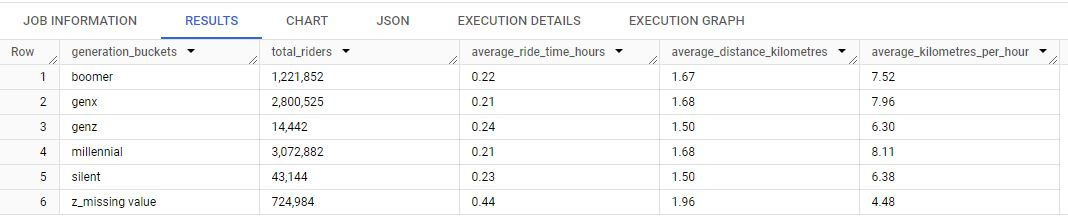